In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os
import pandas as pd
from typing import Dict
import requests
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset

In [2]:
data = pd.read_csv("../data/rJokesData/data/preprocessed.csv.gz")
data = data[["date", "joke", "score"]]
data['date'] = pd.to_datetime(data['date'], unit='s')
print(data.head())
print(data.shape)

                 date                                           joke  score
0 2008-01-25 17:32:47                                A Day in Court     5.0
1 2008-02-10 11:28:57           Photograph of Software project Team     0.0
2 2008-02-10 13:42:54                      what we guys really like     3.0
3 2008-02-29 01:35:58  The Nietzsche Family Circus random generator     3.0
4 2008-03-21 19:47:05                     funny pic: His & Hers SUV     0.0
(573408, 3)


# Generate joke metrics

In [ ]:
def gen_joke_metrics_llm(joke, url="http://localhost:11434/api/generate", model_name="gemma3:12b"):

    system_message = (
        "You are a joke analysis expert. "
        "Your task is to evaluate the following joke based on several key metrics. "
        "For each metric, provide only the numerical value (a continuous scale) on a separate line, without any text, labels, bullet points, or explanations. "
        ""
        "Strictly follow these guidelines:"
        "- Output must contain exactly **6 numerical values**, one per line."
        "- For each metric, feel free to use any number on a continuous scale within the specified range"
        "- Ensure that each number is a single value, not prefixed with labels or any other text. "
        "- **Do NOT** include any labels, bullet points, explanations, or additional text."
        ""
        "The metrics you need to evaluate are as follows: "
        "1. Humor: Rate the joke's funniness from 0.0 (not funny) to 100.0 (extremely funny). "
        "2. Offensiveness: Rate how offensive the joke is from 0.0 (not offensive) to 100.0 (highly offensive). "
        "3. Surprise Factor: Rate how unexpected the punchline is from 0.0 (completely predictable) to 100.0 (highly surprising), based on how well it defies audience expectations. "
        "4. Relatability: Rate how well a general audience can connect with the joke based on personal experience or cultural context. Rate from 0.0 (not relatable) to 100.0 (highly relatable). "
        "5. Conciseness: Rate how efficiently the joke delivers its punchline from 0.0 (too long-winded) to 100.0 (perfectly concise). "
        "6. Sentiment: Rate the overall emotional tone of the joke from -100.0 (very negative) to 100.0 (very positive), with 0.0 being neutral. "
        ""
        "Return **only the numbers, one per line**, without any extra text."
    )

    payload = {
        "model": model_name,
        "system": system_message,
        "prompt": f"Joke:\n{joke}\n\nMetrics:",
        "stream": False,
        "max_tokens": 60,
        "temperature": 0.1
    }
    
    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
        return [-1] * 6  # Return a list with placeholders if request fails
    
    if response.status_code == 200:
        try:
            # Parse and clean the response
            metrics = response.json().get("response", "").strip().split("\n")
            metrics = [i.strip() for i in metrics if i.strip()]  # Clean up any empty lines

            # Ensure there are exactly 6 metrics returned
            if len(metrics) != 6:
                print("Error: Incorrect number of metrics returned.")
                return [-1] * 6  # Return placeholders in case of incorrect metrics count

            # Attempt to convert all metrics to floats
            metrics = [float(i) for i in metrics]
        except (ValueError, KeyError, IndexError) as e:
            print(f"Error processing response: {e}")
            return [-1] * 6  # Return placeholders if error in processing the response
    else:
        print(f"Error: Received status code {response.status_code}")
        return [-1] * 6  # Return placeholders in case of non-200 response

    return metrics
    


In [ ]:
def generate_joke_metrics(data, final_output_path="./data/reddit_joke_train_dataset.parquet", sample_frac=0.1, batch_size=1000):
    """
    Generate joke metrics and save them to a Parquet file in batches.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the jokes.
    - final_output_path (str): The path where the final Parquet file will be saved.
    - sample_frac (float): The fraction of data to sample for metric generation.
    - batch_size (int): Number of rows to process before saving intermediate results.

    Returns:
    - pd.DataFrame: The DataFrame containing the jokes and their generated metrics.
    """

    # Sample the data
    sampled_data = data.sample(frac=sample_frac, random_state=42)

    # Load existing data if the Parquet file exists
    if os.path.exists(final_output_path):
        existing_data = pd.read_parquet(final_output_path)
        processed_indices = set(existing_data.index)
    else:
        existing_data = None
        processed_indices = set()

    # Get the remaining rows that have not been processed
    remaining_rows = sampled_data.loc[~sampled_data.index.isin(processed_indices)]

    # If there are no remaining rows, return the existing data
    if remaining_rows.empty:
        return existing_data

    # Process and save in batches
    new_data_list = []
    for start in tqdm(range(0, len(remaining_rows), batch_size), desc="Processing batches"):
        batch = remaining_rows.iloc[start:start + batch_size]

        # Generate metrics for the batch
        metrics_list = [gen_joke_metrics_llm(joke) for joke in batch['joke']]

        # Convert to DataFrame
        metrics_df = pd.DataFrame(metrics_list, columns=[
            'humor', 'offensiveness', 'surprise_factor', 'relatability', 'conciseness', 'sentiment'
        ])
        metrics_df.index = batch.index

        # Append metrics to batch
        batch = pd.concat([batch, metrics_df], axis=1)
        new_data_list.append(batch)

        # Merge with existing data and save after each batch
        final_data = pd.concat([existing_data, *new_data_list]) if existing_data is not None else pd.concat(new_data_list)
        final_data.to_parquet(final_output_path)
        
    return final_data


# Assuming 'data' is your original DataFrame
final_result = generate_joke_metrics(data, final_output_path="./data/_tmp.parquet", sample_frac=0.001, batch_size=3)

Processing batches:  71%|███████   | 122/172 [08:31<03:28,  4.17s/it]

Error: Incorrect number of metrics returned.


Processing batches: 100%|██████████| 172/172 [13:00<00:00,  4.54s/it]


In [11]:
final_result

,date,joke,score,humor,offensiveness,surprise_factor,relatability,conciseness,sentiment
412005,2018-08-23 13:28:10,What does a racist joke and crossing the stree...,17810.0,2.0,85.0,15.0,10.0,75.0,-60.0
161935,2016-04-15 20:04:30,I have spent the past year looking for my ex's...,2.0,35.0,5.0,70.0,65.0,90.0,-20.0
138637,2015-12-19 15:24:52,Why is. Dr.Dre's Headphones so popular? Beats me.,1.0,65.0,5.0,70.0,40.0,90.0,10.0
446460,2018-12-17 23:55:09,I wish I could be like Jesus Christ... That so...,6.0,35.0,75.0,60.0,20.0,90.0,-40.0
486819,2019-04-15 11:12:03,Why did the seagull fly over the sea? Because ...,10.0,35.0,5.0,75.0,60.0,90.0,15.0
...,...,...,...,...,...,...,...,...,...
481083,2019-03-29 16:56:38,"I like my women like Lord Jesus Long Hair, and...",0.0,35.0,15.0,65.0,20.0,80.0,-70.0
312091,2017-08-25 03:50:00,What did Hurricane Harvey say to the coconut p...,12.0,3.5,95.0,15.0,20.0,80.0,-60.0
208821,2016-09-27 20:38:53,I decided to vote for the most presidential an...,5.0,65.0,2.0,75.0,40.0,90.0,15.0
158812,2016-03-27 13:31:43,What has four legs and one arm? An attack dog ...,69.0,35.0,15.0,65.0,40.0,80.0,-5.0


In [ ]:
final_result = final_result[final_result["humor"] > -1]
final_result.to_parquet("../data/labeled_jokes.parquet")

# Additional Analysis

In [ ]:
d = pd.read_parquet("/Users/sawale/Documents/LLM-based-data-filtering/data/reddit_joke_train_dataset.parquet")


d = d[d["humor"] != -1]
d.head()

,date,joke,score,humor,offensiveness,clarity,surprise_factor,relatability,novelty,conciseness,sentiment
412005,2018-08-23 13:28:10,What does a racist joke and crossing the stree...,17810.0,3.0,85.0,15.0,2.0,10.0,1.0,70.0,-60.0
161935,2016-04-15 20:04:30,I have spent the past year looking for my ex's...,2.0,65.0,15.0,80.0,75.0,70.0,30.0,90.0,-20.0
138637,2015-12-19 15:24:52,Why is. Dr.Dre's Headphones so popular? Beats me.,1.0,65.0,1.0,90.0,75.0,45.0,30.0,95.0,20.0
446460,2018-12-17 23:55:09,I wish I could be like Jesus Christ... That so...,6.0,65.0,25.0,80.0,75.0,30.0,15.0,90.0,-40.0
486819,2019-04-15 11:12:03,Why did the seagull fly over the sea? Because ...,10.0,65.0,1.0,85.0,75.0,30.0,40.0,95.0,10.0


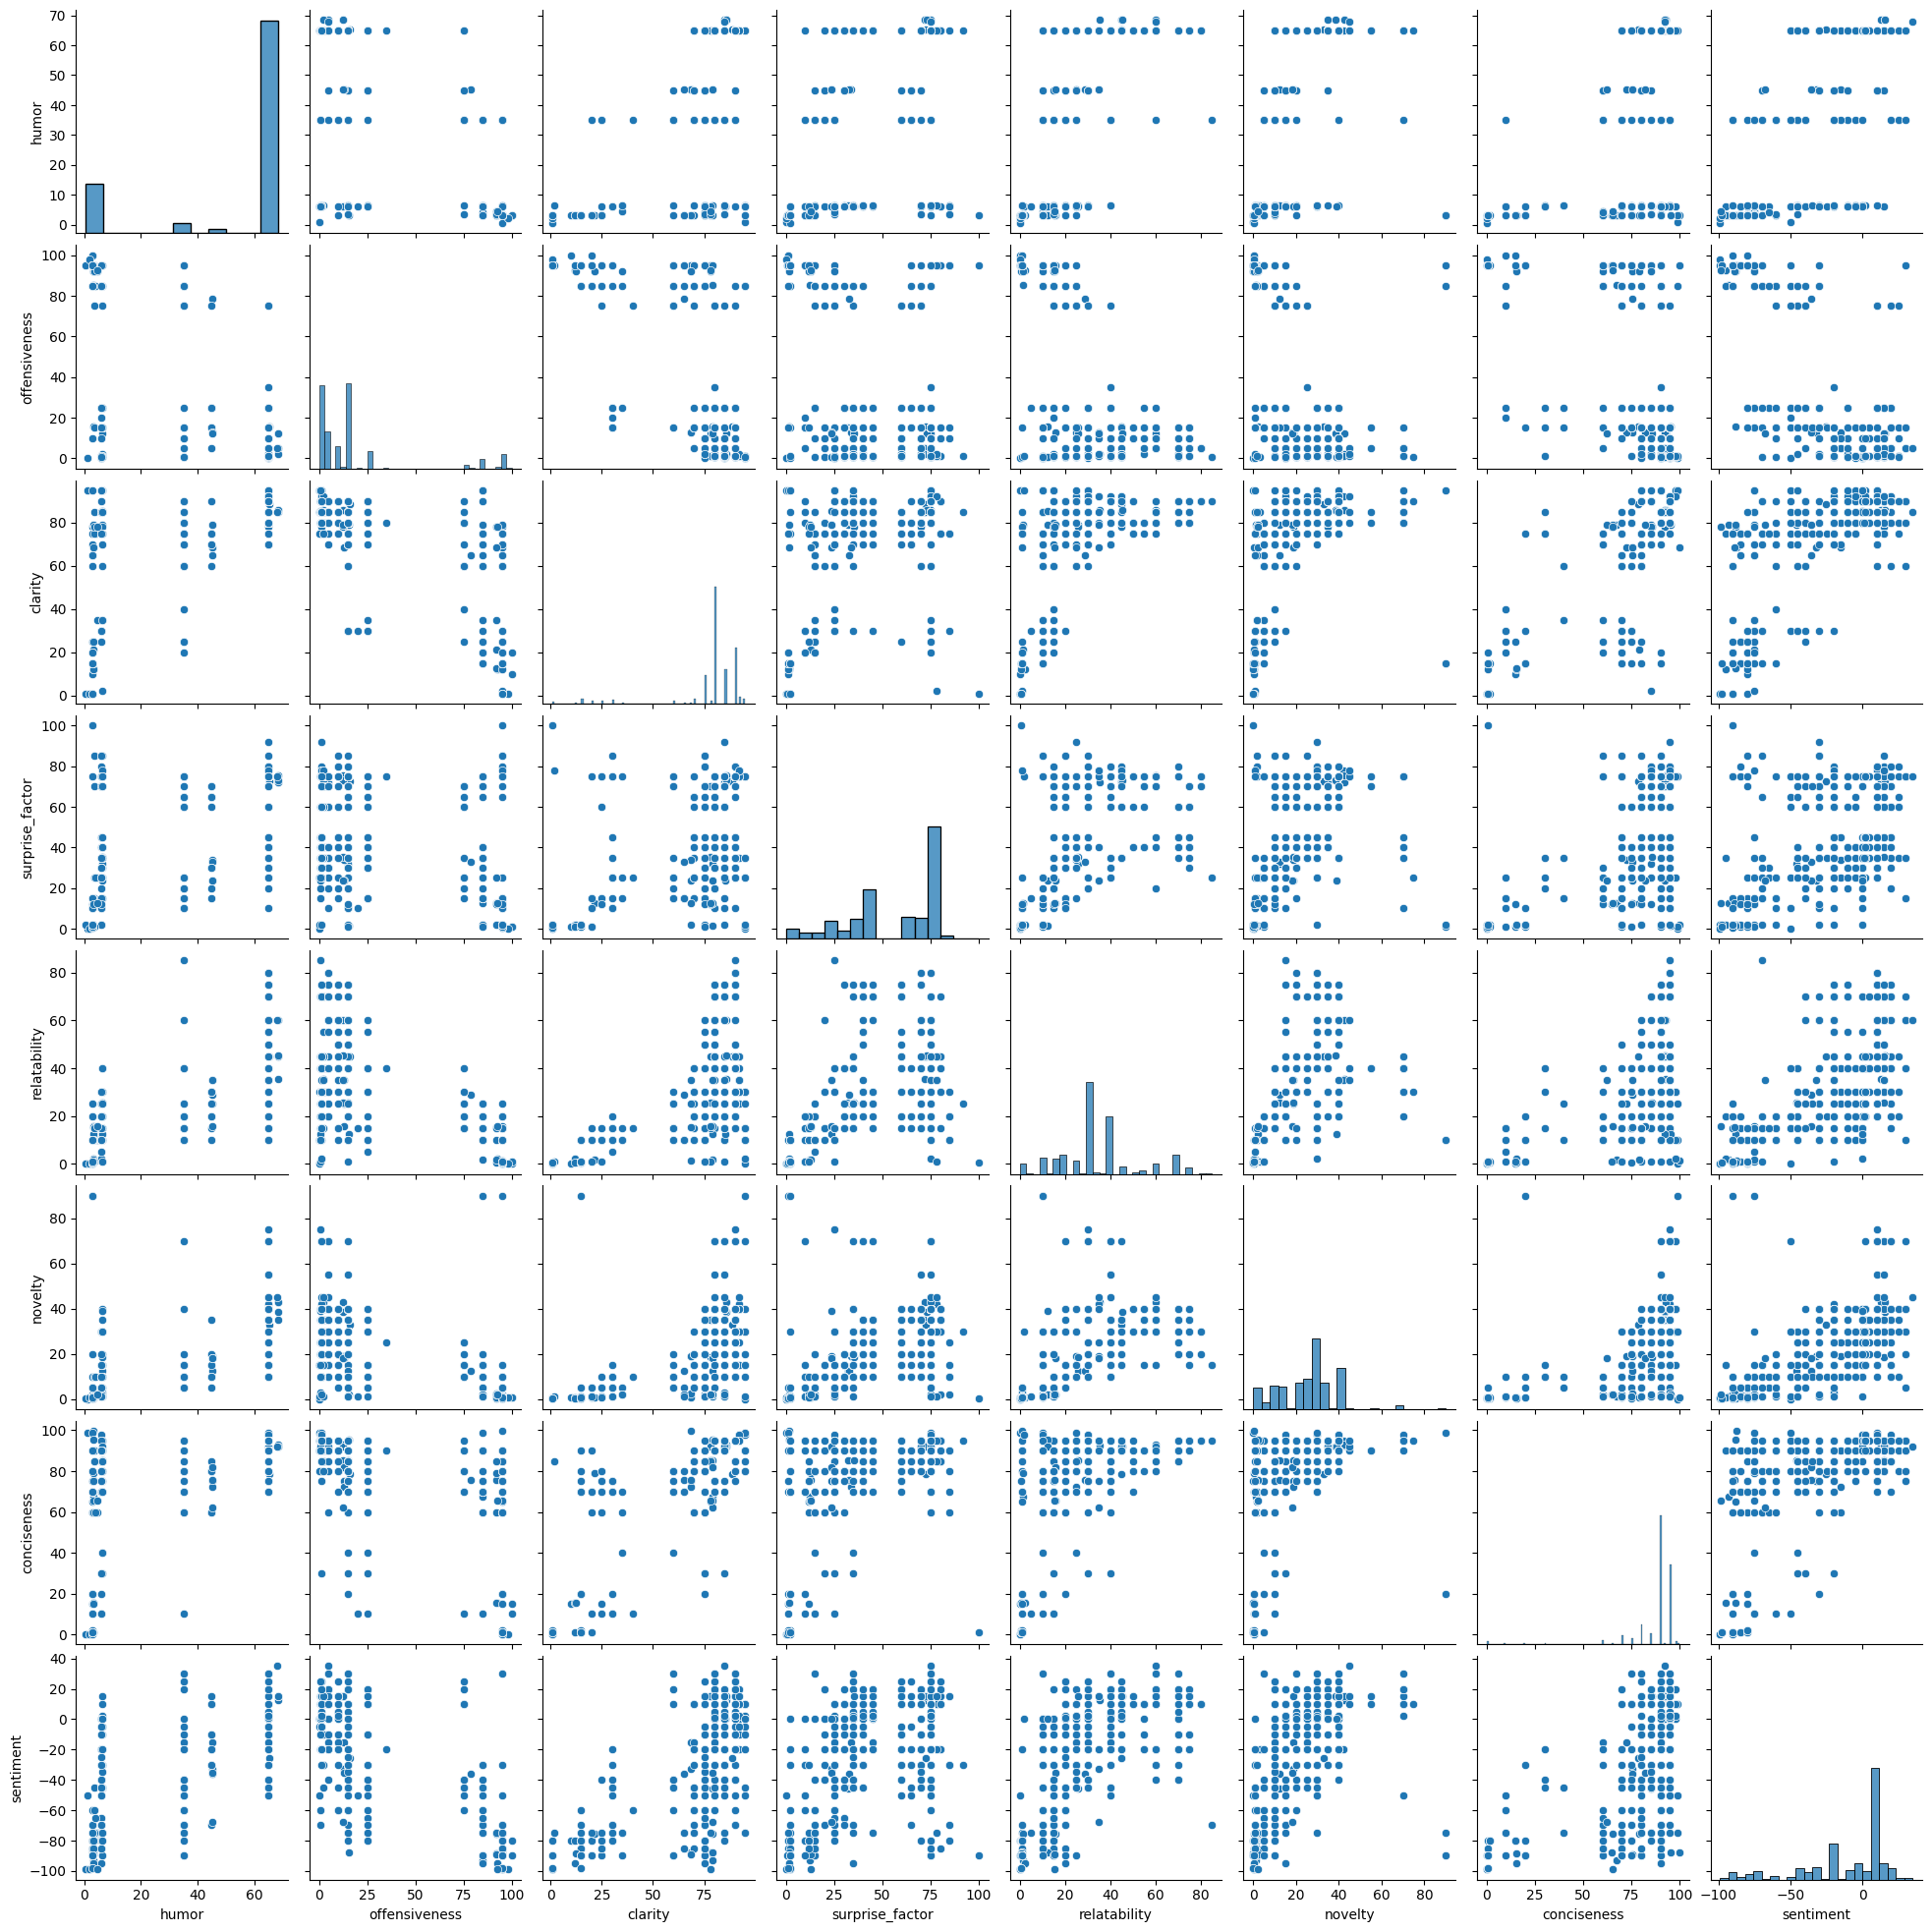

In [ ]:
# Pairplot to visualize relationships
sns.pairplot(d[["humor","offensiveness"	,"clarity"	,"surprise_factor"	,"relatability"	,"novelty"	,"conciseness"	,"sentiment"]].head(1000))
plt.show()



In [103]:
d["ho"] = d["humor"] + d["offensiveness"]
x = d.sort_values(by=['ho'])

x.tail()

,source,joke,humor,offensiveness,clarity,ho
79834,reddit,"What do you get when you put jelly into Flint,...",6.0,8.0,7.0,14.0
12794,reddit,My girlfriend broke up with me because I stole...,6.0,8.0,7.0,14.0
131115,reddit,Why are the saxophone afraid of the trombone?\...,6.5,8.0,9.0,14.5
144918,reddit,What do you call a paralyzed clown with his to...,6.5,8.0,9.0,14.5
197771,reddit,Customer asking Bin Laden in Bar ( i need /u/y...,6.5,8.0,9.0,14.5


In [109]:
x.iloc[-6]["joke"]

"I think armless persons are the best\nYou've gotta hand it to them."

In [1]:
import pandas as pd

d = pd.read_csv("/Users/sawale/Documents/LLM-based-data-filtering/data/rJokesData/data/preprocessed.csv")

d["len"] = d["joke"].str.len()

d.sort_values(by='len')

,joke,body,punchline,score,date,len
95366,1,NaN,1,0.000000e+00,1.432504e+09,2.0
545916,👌,NaN,👌,1.000000e+00,1.570562e+09,2.0
472815,Đ,NaN,Đ,1.000000e+00,1.551852e+09,2.0
360140,😂,NaN,😂,1.000000e+00,1.519614e+09,2.0
105348,X,NaN,X,0.000000e+00,1.437158e+09,2.0
...,...,...,...,...,...,...
43427,NaN,"If we are going lose the Washington Redskins,",22,1.403278e+09,NaN,NaN
44091,NaN,Two men walk into a bar,0,1.403999e+09,NaN,NaN
81773,NaN,What's a dogs favorite TV show?,5,1.426781e+09,NaN,NaN
141236,NaN,Q: What has two legs and bleeds?,0,1.451720e+09,NaN,NaN


In [5]:
40000/3

13333.333333333334

In [4]:
# p = pd.read_parquet("/Users/sawale/Documents/LLM-based-data-filtering/data/reddit_joke_train_dataset.parquet")

import pyarrow.parquet as pq

try:
    pq.ParquetFile("/Users/sawale/Documents/LLM-based-data-filtering/data/reddit_joke_train_dataset.parquet")
    print("File is a valid Parquet file.")
except Exception as e:
    print("Error:", e)


Error: Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.


In [1]:
import pandas as pd

# df = pd.read_parquet("/Users/sawale/Documents/LLM-based-data-filtering/data/reddit_joke_train_dataset.parquet", engine="fastparquet")


from fastparquet import ParquetFile

pf = ParquetFile("/Users/sawale/Documents/LLM-based-data-filtering/data/reddit_joke_train_dataset.parquet")
df = pf.to_pandas()
df.to_parquet("recovered.parquet")  # Save a new version



OSError: [Errno 22] Invalid argument

In [5]:
import pyarrow.parquet as pq

file_path = "/Users/sawale/Documents/LLM-based-data-filtering/data/reddit_joke_train_dataset.parquet"
try:
    table = pq.read_table(file_path)
    print(table)
except Exception as e:
    print(f"Error reading file: {e}")


Error reading file: Error creating dataset. Could not read schema from '/Users/sawale/Documents/LLM-based-data-filtering/data/reddit_joke_train_dataset.parquet'. Is this a 'parquet' file?: Could not open Parquet input source '/Users/sawale/Documents/LLM-based-data-filtering/data/reddit_joke_train_dataset.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.


In [ ]:



p = p.sort_values(by="surprise_factor").tail(30)

p

,date,joke,score,humor,offensiveness,clarity,surprise_factor,relatability,novelty,conciseness,sentiment
165256,2016-05-02 01:08:25,What do you call a positive transformer? Optim...,1.0,75.0,1.0,90.0,65.0,40.0,60.0,95.0,30.0
360332,2018-02-26 20:28:11,So I got my concealed carry permit yesterday S...,100.0,68.5,2.3,85.7,72.1,45.9,55.2,91.4,12.8
498475,2019-05-17 17:28:25,"A young boy is jogging away from school, with ...",6.0,68.5,2.3,85.7,72.1,61.9,45.2,91.4,12.8
311174,2017-08-21 22:30:39,Chuck Norris looked directly at the sun today....,23271.0,68.5,5.2,85.1,72.3,38.7,12.9,91.4,25.6
198316,2016-08-25 09:20:00,A Buddhist goes to a hot-dog seller A Buddhist...,1.0,68.5,12.3,85.7,72.9,45.2,58.1,91.4,35.6
179888,2016-06-24 18:28:00,A man has a conversation with God Man: How muc...,41.0,68.5,2.3,85.1,72.9,45.7,38.2,92.6,12.4
320933,2017-09-28 13:02:18,What's the name of a metal band longing for th...,2.0,68.5,12.3,85.7,72.9,35.2,78.1,92.6,15.4
85928,2015-04-07 22:06:58,My girlfriend got a tattoo of a seashell on he...,120.0,68.5,12.3,85.7,72.9,48.2,35.1,91.4,18.6
371497,2018-04-05 21:17:37,I was fired from my position as a data wrangle...,3.0,68.5,2.3,85.2,72.9,48.7,55.1,92.6,35.4
67167,2014-12-30 19:52:57,I used to play hard to get until I realized th...,21.0,68.5,12.3,85.7,72.9,45.2,38.1,91.4,15.6


In [ ]:



p = p.sort_values(by="surprise_factor").tail(30)

p

,date,joke,score,humor,offensiveness,clarity,surprise_factor,relatability,novelty,conciseness,sentiment
165256,2016-05-02 01:08:25,What do you call a positive transformer? Optim...,1.0,75.0,1.0,90.0,65.0,40.0,60.0,95.0,30.0
360332,2018-02-26 20:28:11,So I got my concealed carry permit yesterday S...,100.0,68.5,2.3,85.7,72.1,45.9,55.2,91.4,12.8
498475,2019-05-17 17:28:25,"A young boy is jogging away from school, with ...",6.0,68.5,2.3,85.7,72.1,61.9,45.2,91.4,12.8
311174,2017-08-21 22:30:39,Chuck Norris looked directly at the sun today....,23271.0,68.5,5.2,85.1,72.3,38.7,12.9,91.4,25.6
198316,2016-08-25 09:20:00,A Buddhist goes to a hot-dog seller A Buddhist...,1.0,68.5,12.3,85.7,72.9,45.2,58.1,91.4,35.6
179888,2016-06-24 18:28:00,A man has a conversation with God Man: How muc...,41.0,68.5,2.3,85.1,72.9,45.7,38.2,92.6,12.4
320933,2017-09-28 13:02:18,What's the name of a metal band longing for th...,2.0,68.5,12.3,85.7,72.9,35.2,78.1,92.6,15.4
85928,2015-04-07 22:06:58,My girlfriend got a tattoo of a seashell on he...,120.0,68.5,12.3,85.7,72.9,48.2,35.1,91.4,18.6
371497,2018-04-05 21:17:37,I was fired from my position as a data wrangle...,3.0,68.5,2.3,85.2,72.9,48.7,55.1,92.6,35.4
67167,2014-12-30 19:52:57,I used to play hard to get until I realized th...,21.0,68.5,12.3,85.7,72.9,45.2,38.1,91.4,15.6


In [45]:
print(p.iloc[-3]["joke"])

Is hell endothermic or exothermic? Most of the students wrote proofs of their beliefs using Boyle's Law (gas cools when it expands and heats when it is compressed) or some variant.  One student, however, wrote the following:  First, we need to know how the mass of Hell is changing in time. So we need to know the rate at which souls are moving into Hell and the rate at which they are leaving. I think that we can safely assume that once a soul gets to Hell, it will not leave. Therefore, no souls are leaving.  As for how many souls are entering Hell, let's look at the different Religions that exist in the world today. Most of these religions state that if you are not a member of their religion, you will go to Hell. Since there is more than one of these religions and since people do not belong to more than one religion, we can project that all souls go to Hell.  With birth and death rates as they are, we can expect the number of souls in Hell to increase exponentially. Now, we look at the 

In [13]:


import pandas as pd
x = pd.read_parquet("/Users/sawale/Documents/LLM-based-data-filtering/data/joke_metrics_dataset_1/")

x.shape

(57341, 11)

In [16]:
x.describe()

,date,score,humor,offensiveness,clarity,surprise_factor,relatability,novelty,conciseness,sentiment
count,57330,5.733200e+04,57341.000000,57341.000000,57341.000000,57341.000000,57341.000000,57341.000000,57341.000000,57341.000000
mean,2017-04-01 13:10:07.778754560,4.956542e+04,55.320532,14.398171,79.673781,62.938447,29.590065,22.255006,87.729933,-7.627307
min,2008-02-10 13:42:54,0.000000e+00,-1.000000,-20.000000,-1.000000,-1.000000,-1.000000,-1.000000,-98.700000,-100.000000
25%,2016-01-18 19:34:06.249999872,1.000000e+00,65.000000,5.000000,80.000000,65.000000,20.000000,15.000000,90.000000,-20.000000
50%,2017-05-26 19:20:58,5.000000e+00,65.000000,5.000000,85.000000,75.000000,30.000000,20.000000,90.000000,10.000000
75%,2018-10-26 00:33:00,2.000000e+01,65.000000,15.000000,85.000000,75.000000,30.000000,30.000000,95.000000,10.000000
max,2019-12-31 23:07:32,1.434820e+09,78.500000,100.000000,98.700000,100.000000,90.000000,99.900000,100.000000,100.000000
std,NaN,8.357623e+06,18.622824,23.148392,14.155148,21.098063,13.363649,12.081796,13.990399,30.783544
